# COVID-19 Dashboard - Canada

### This is a dashboard for visualizing Canadian COVID statistics using the OpenCOVID API.

By default, daily new infections and daily deaths will be visualized if data regarding only a specific health region is queried. For data queried at a provincial, territorial, or national level, visualizations concerning hospitalizations and ICU occupancies will also be included. 

While this is currently the only data visualized, the OpenCOVID API also includes support for additional data at the provincial, territorial, or national level, regarding COVID testing, vaccine administration, and vaccine coverage, with data being separable for each vaccine dose up to and including the fourth. Additional support for the extended data as well as additional data representations such as tables are being considered for this dashboard for future updates. 

***

Requested data can be customized via editing the following four parameters, as follows: 



In [57]:
# PARAMS: change these to see different data
# All dates must follow the format YYYY-MM-DD

geographic_data_level = 'pt'
# This can be 'pt' for provincial or territorial, 'hr' for health region, or 'can' for the entirety of Canada. 

start_date = '2023-01-01'
# This is the first day that you want to see data for. Nothing before this date will be shown.

end_date = '2023-02-01'
# This is the final day that you want to see data for. Nothing after this date will be shown.

The final parameter is our location ID. This is either a two letter province or territory abbreviation, or a three or four digit health region code. Please note that hospitalization data is only provided for data at or above the provincial level. In the event that data is only requested for a specific health region, only case and death data are available. This is a limit of the OpenCOVID API, which this notebook uses.   

[The lookup table for individual health regions and provincial abbreviations can be found here:](https://github.com/ccodwg/CovidTimelineCanada/blob/main/geo/hr.csv)

https://github.com/ccodwg/CovidTimelineCanada/blob/main/geo/hr.csv

For health region codes, refer to values under the column `hruid`, and for provincial abbreviations, please reference the values under the column labelled `region`.

In [58]:
# PARAM: change this to see different data

location_ID = 'ON'

# This is either a two letter province or territory abbreviation, or a three or four digit health region code.
# Examples would be 'BC' for British Columbia, 'AB' for Alberta, '593' for Vancouver Coastal Health, or '4601' for Winnipeg Regional Health Authority. 
# If you want to see data for the entirety of Canada, change this to an empty string - ''.

The following code runs using our provided parameters from above. Let's begin by importing the modules we'll need for our dashboard. 

In [59]:
import datetime, json, requests
import matplotlib.pyplot as plt
import  matplotlib.dates as mdates
%matplotlib inline

Next, we can define a few functions that'll be used multiple times for processing data. We'll starting with a `rolling_avg` function that returns a list of rolling averages based on a specified window size, a `format_date_axis` function that'll be used to format the dates on the X-axis of our plots, and a `subquery_data` function that helps us process specific kinds of information returned from our API call. We'll also include `final_value_label` to help us save on repetition when we're annotating our final values for each line plot. 

In [60]:
def rolling_avg(data, window_size):
    '''returns a list of rolling averages for a given list of data, using a given window size'''
    return [sum(data[i-window_size:i])/window_size for i in range(window_size, len(data))] # list comprehension that calculates the rolling average for each day.
    # we'll be using this almost exclusively for 7-day rolling averages, but it can be used for any window size.

def format_date_axis(ax):
    '''format the dates shown on the x-axis of given axes, ax'''
    locator = mdates.AutoDateLocator(minticks=10, maxticks=20) # set the number of ticks on the x-axis
    formatter = mdates.ConciseDateFormatter(locator) # format the dates shown on the x-axis 
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter) 

def subquery_data(query_type, result_data, value_type):
    '''used to gather information for the subqueries for pt and above, such as hospitalizations, ICU counts, and tests.'''
    query_data = result_data[query_type] # get the data for the subquery
    query_dates = [daily['date'] for daily in query_data] # extract the date strings
    n_query = [daily[value_type] for daily in query_data] # extract the data values - whether we want daily or cumulative values
    query_datetime_objects = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in query_dates] # convert the date strings to datetime objects
    query_dates = [dt.date() for dt in query_datetime_objects] # convert the datetime objects to date objects
    # query 7-day rolling averages
    if query_type != 'deaths':
        # not all provinces and health regions report deaths on a daily basis, so the rolling average would be misleading.
        # we'll only generate rolling averages for the other subqueries.
        query_rolling = rolling_avg(n_query, 7) # calculate the 7-day rolling average
        query_dates_rolling = query_dates[7:] 
        return query_dates, n_query, query_dates_rolling, query_rolling
    else:
        # in the event that we ARE looking at deaths, we don't need to return the rolling averages.
        return query_dates, n_query

def final_value_label(ax, value, color):
    '''add a label to the right side of the graph showing the final value'''
    ax.annotate(f'{int(value[-1])}', xy=(1, value[-1]), xycoords=('axes fraction', 'data'), ha = 'left', va = 'center', color = color)

Now that we have our tools ready, we're ready to make our API call using the parameters declared at the start of this notebook. We'll be using basic string concatenation for this. 

In [61]:
# string concatenation to create the query URL
query = 'https://api.opencovid.ca/timeseries?geo=' + geographic_data_level + '&loc=' + location_ID + '&after=' + start_date + '&before=' + end_date
# api call uses the default value for stat, returning all available data.
# this data isn't as comprehensive when it's requested for a specific HR instead of PT or above, so 
# the additional data provided for provincial queries and above will be handled behind an if statement.
response = requests.request("GET", query, headers={}, data={}) # make the request
result = json.loads(response.text) # convert the response to a json object
result_data = result['data'] # get the data from the json object

Finally, we're ready to go through the raw data with our `subquery_data` function to pick out what exactly we're looking for and plot it with matplotlib. 

We'll also clarify how many plots we'll be making here: if we're only looking at a health region (`hr`), we'll only have access to data regarding daily infections and daily deaths (and even the deaths might not necessarily be updated daily!) so we'll only need 2 plots. However, if we're looking at data at a provincial level or higher (`pt` or `can`), we'll also have hospitalization and ICU patient numbers - so we'll have a total of 4 plots instead. 

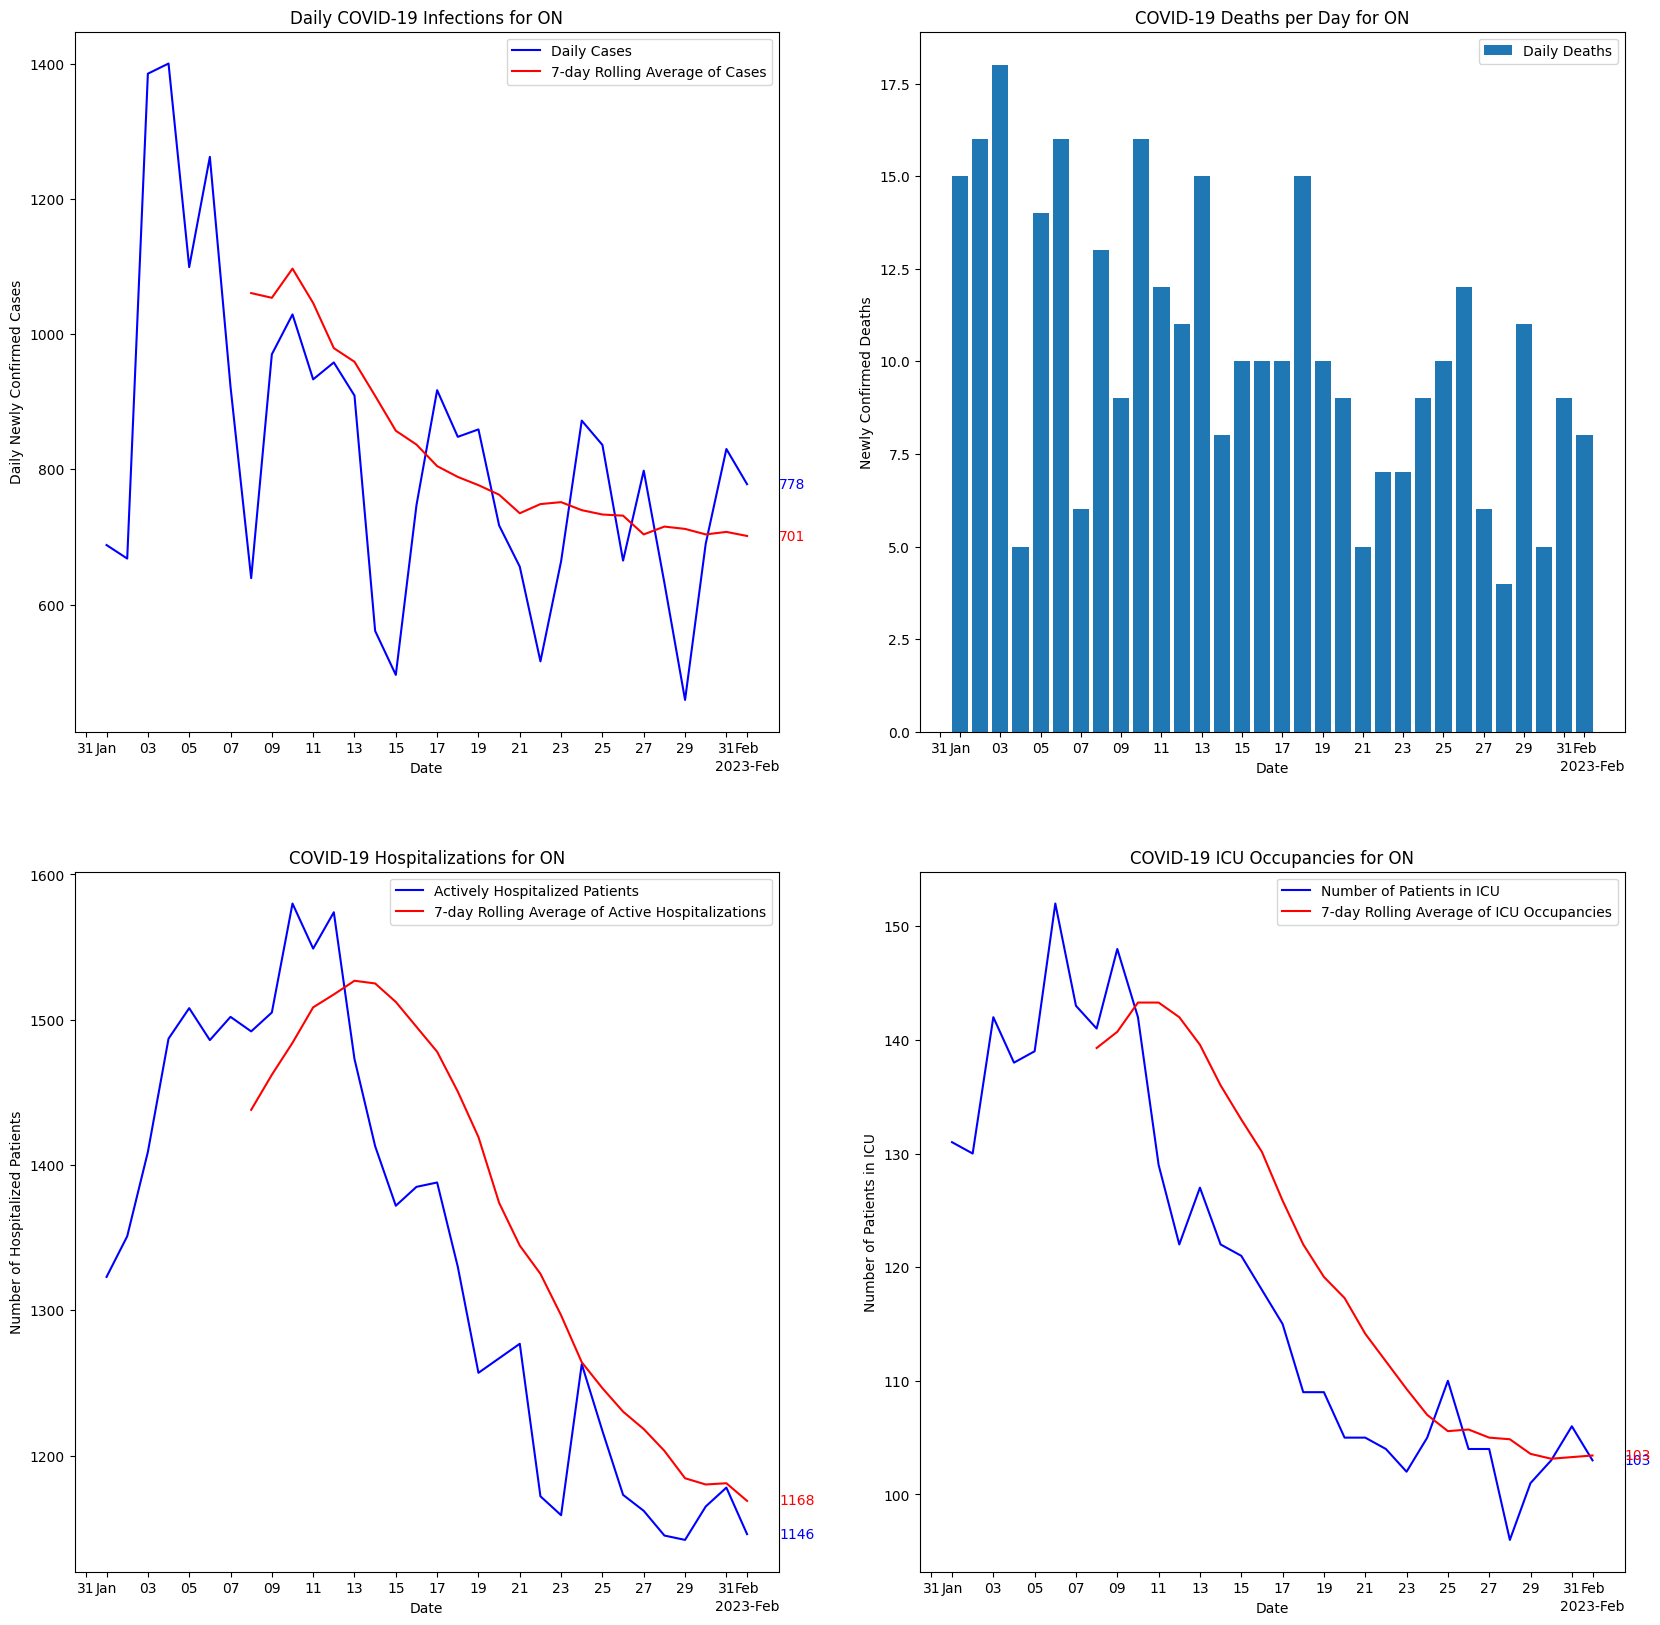

In [62]:
if geographic_data_level != 'hr':
    # fig, [[ax1, ax2], [ax3, ax4], [ax5, ax6]] = plt.subplots(nrows=3, ncols=2, figsize = [20,30])
    # two of the charts have been removed as vaccine coverage is only updated once per month, as is testing data, and it doesn't plot well.
    fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize = [20,20]) # create the figure - a 2 x 2 plot of subplots
else:
    fig, [ax1, ax2] = plt.subplots(nrows=2, figsize = [20,20]) # create the figure and axes - 2 plots in 2 rows. 

# case data
case_dates, n_cases, cases_dates_rolling, cases_rolling = subquery_data('cases', result_data, 'value_daily')
format_date_axis(ax1)
ax1.plot(case_dates, n_cases, c ='b', label='Daily Cases')  # Plot some data on the axes.
ax1.plot(cases_dates_rolling, cases_rolling, c='r', label='7-day Rolling Average of Cases')
ax1.set_xlabel('Date')  # Add an x-label to the axes.
ax1.set_ylabel('Daily Newly Confirmed Cases')  # Add a y-label to the axes.
ax1.set_title(f'Daily COVID-19 Infections for {location_ID}')  # Add a title to the axes.
final_value_label(ax1, n_cases, 'b')
final_value_label(ax1, cases_rolling, 'r')
ax1.legend() # make sure to add the legend to the plot. it won't show up otherwise, even if we've added labels to the lines.

# death data
death_dates, n_deaths = subquery_data('deaths', result_data, 'value_daily')
'''plot deaths as a bar chart using matplotlib'''
ax2.bar(death_dates, n_deaths, label='Daily Deaths')  # Plot some data on the axes.
format_date_axis(ax2) 
# the date axis formatting function doesn't actually work particularly well with the bar chart, particularly when it comes to health regions
# or provinces that might not update this value daily. it works well for line charts, though, and works well enough for provinces that DO update
# daily, so we'll keep it for now. it's likely to get an update in the future.
ax2.set_xlabel('Date')  # Add an x-label to the axes.
ax2.set_ylabel('Newly Confirmed Deaths')  # Add a y-label to the axes.
ax2.set_title(f'COVID-19 Deaths per Day for {location_ID}') 
ax2.legend()

# if we're looking at the provincial level or higher, we can include graphs for additional data as well.
# otherwise, if we're only looking at a specific health region, we only need two graphs - one for cases and one for deaths, so this is skipped.
if geographic_data_level != 'hr':
    # hospitalization data
    hosp_dates, n_hosp, hosp_dates_rolling, hosp_rolling = subquery_data('hospitalizations', result_data, 'value')
    # plot hospitalizations as a line graph using matplotlib
    ax3.plot(hosp_dates, n_hosp, c ='b', label='Actively Hospitalized Patients')  # Plot some data on the axes.
    ax3.plot(hosp_dates_rolling, hosp_rolling, c='r', label='7-day Rolling Average of Active Hospitalizations')
    format_date_axis(ax3)
    ax3.set_xlabel('Date')  # Add an x-label to the axes.
    ax3.set_ylabel('Number of Hospitalized Patients')  # Add a y-label to the axes.
    ax3.set_title(f'COVID-19 Hospitalizations for {location_ID}')  # Add a title to the axes.
    final_value_label(ax3, n_hosp, 'b')
    final_value_label(ax3, hosp_rolling, 'r')
    ax3.legend()

    # ICU data
    icu_dates, n_icu, icu_dates_rolling, icu_rolling = subquery_data('icu', result_data, 'value')
    # plot ICU as a line graph using matplotlib
    ax4.plot(icu_dates, n_icu, c ='b', label='Number of Patients in ICU')  # Plot some data on the axes.
    ax4.plot(icu_dates_rolling, icu_rolling, c='r', label='7-day Rolling Average of ICU Occupancies')
    format_date_axis(ax4)
    ax4.set_xlabel('Date')  # Add an x-label to the axes.
    ax4.set_ylabel('Number of Patients in ICU')  # Add a y-label to the axes.
    ax4.set_title(f'COVID-19 ICU Occupancies for {location_ID}')  # Add a title to the axes.
    final_value_label(ax4, n_icu, 'b')
    final_value_label(ax4, icu_rolling, 'r')
    ax4.legend()

    # vaccine coverage data
    # this code works perfectly fine, but it's been removed for now due to the fact that vaccine coverage is only updated once per month.
    '''colors = ['b', 'y', 'g', 'r']
    for i in range(1,5):
        vax_dates, n_vax, vax_dates_rolling, vax_rolling = subquery_data(f'vaccine_coverage_dose_{i}', result_data, 'value')
        # plot vaccine coverage as line graphs using matplotlib
        ax5.plot(vax_dates, n_vax, c = colors[i-1], label=f'Dose {i}')
        ax5.annotate(f'{n_vax[-1]:.2f}', xy=(1,n_vax[-1]), xycoords=('axes fraction', 'data'), 
                     ha='left', va='center', color=colors[i-1])
    ax5.set_xlabel('Date')  # Add an x-label to the axes.
    ax5.set_ylabel('Percentage of Population With Dose Administered')  # Add a y-label to the axes.
    ax5.set_title(f'COVID-19 Vaccine Coverage for {location_ID}')  # Add a title to the axes.
    ax5.legend()'''

    # testing data
    # same issue as vaccine coverage data - thus not included in the final implementation. 

If your `geographic_data_level` was `hr`, there should be two graphs presented above. If it was `pt` or `can`, you should be seeing four graphs above. Additional graphs pertaining to vaccination rates and the number of tests being performed have been temporarily disabled, as those values are only updated once per month, and don't graph well. 

Final values for each line shown on a lineplot are displayed as annotations in their corresponding graphs, and are color coded for ease of use. Additionally, the line graphs are color-coded: the lines representing daily data are shown in `blue`, while the lines representing seven-day rolling averages are displayed in `red`. Hopefully, the added contrast aids in ease of use. Please feel free to contact me with concerns regarding accessibility issues, should any arise, and I'll do my best to hopefully implement a solution as fast as possible. 

The date axis labels could be improved upon slightly, particularly when displaying data that might not be updated daily (specifically, the death counts - not every province and health region updates this information on a daily basis, and some organizations only provide data once per week. While this isn't as bad as the once-a-month updates such as those for vaccination and testing, it still make the axis label slightly messier than it needs to be. )

